In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from SARIMAX import *
%load_ext autoreload
%autoreload 2

In [2]:
# Set file path and parameters
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"

In [3]:
# Choose features
loader = DataLoader(file_path, use_temp=True, use_wind=False, use_oil=False, use_gas=False)
loader.load_data()
spot_price, exog_data = loader.preprocess_data()

engineer = FeatureEngineer(use_fourier=True, use_pca=True)
exog_features = engineer.transform(spot_price, exog_data)

spot_price = spot_price.sort_index()
exog_features = exog_features.sort_index()

In [4]:
train_end = '2024-07-31'
latest_1000 = -1000
train_data = spot_price[:train_end].iloc[latest_1000:]
train_exog = exog_features.loc[:train_end].iloc[latest_1000:]

In [5]:
# 3. Create Training and Test Sets
train_data = spot_price[:train_end].iloc[latest_1000:]
train_exog = exog_features.loc[:train_end].iloc[latest_1000:]


In [6]:
model = SARIMAWrapper(order=(2,0,0), seasonal_order=(1,0,2,24))
results = model.fit(train_data, train_exog)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13097D+00    |proj g|=  2.00061D-01


 This problem is unconstrained.



At iterate    5    f=  6.08211D+00    |proj g|=  9.93713D-02

At iterate   10    f=  6.04177D+00    |proj g|=  2.16049D-02

At iterate   15    f=  6.02726D+00    |proj g|=  1.09215D-02

At iterate   20    f=  6.00200D+00    |proj g|=  3.06133D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     23     38      1     0     0   8.851D-03   5.999D+00
  F =   5.9989659829902582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [7]:
forecast_start = pd.Timestamp('2024-08-01 00:00:00')
forecast_end = pd.Timestamp('2024-08-08 00:00:00')
forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='h')

forecasts = model.bulk_forecast(forecast_index, exog_features, use_past_24h=True)

actual_prices = spot_price.loc[forecast_index]

In [8]:
mae = mean_absolute_error(actual_prices, forecasts)
rmse = np.sqrt(mean_squared_error(actual_prices, forecasts))
print("MAE:", mae)
print("RMSE:", rmse)


MAE: 245.3219037918765
RMSE: 315.77705690949153


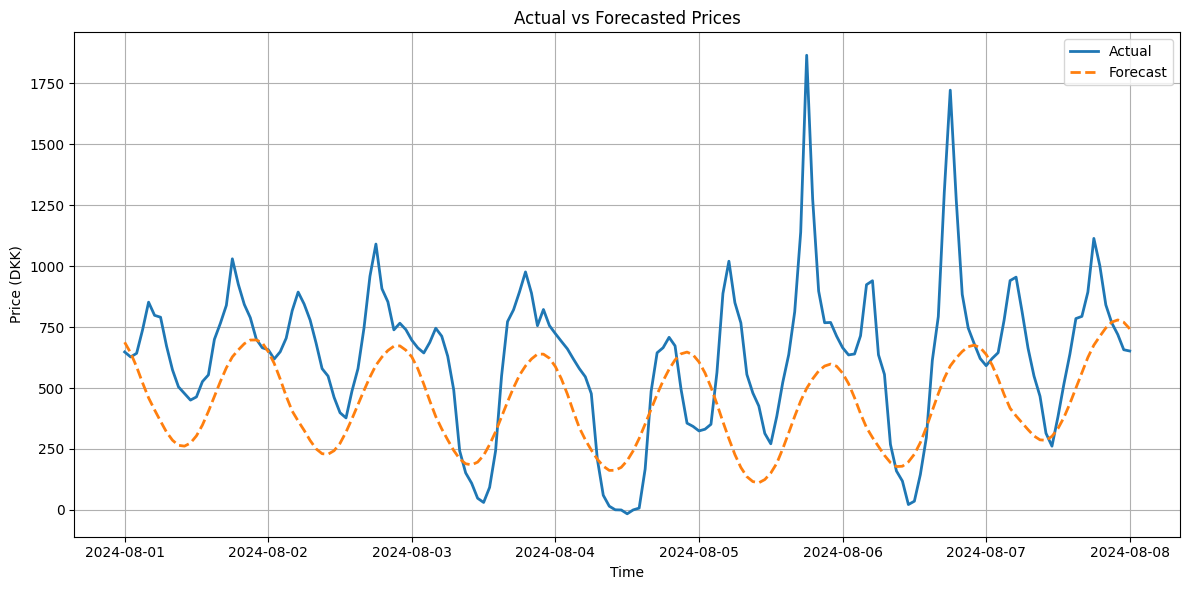

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(actual_prices.index, actual_prices, label='Actual', linewidth=2)
plt.plot(forecasts.index, forecasts, label='Forecast', linewidth=2, linestyle='--')
plt.title('Actual vs Forecasted Prices')
plt.xlabel('Time')
plt.ylabel('Price (DKK)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()